## FeatureImportanceSummarizer

This Not That (TNT) provides a plot viewer to help a user gain a better understanding of their summarized data.  We will outline the basic functionality of this `PlotSummaryPane` by demonstrating it with a one of TNT's build in summary functions: `FeatureImportanceSummarizer`.

The first step is to load `thisnotthat` and `panel`.

In [1]:
import thisnotthat as tnt
import panel as pn

2023-02-27 17:38:54.131576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


To make Panel based objects interactive within a notebook we need to load the panel `extension`.

In [2]:
pn.extension()

Now we need some data to use as an example. In this case we’ll use the Palmer’s Penguins dataset, which we can get easy access to via seaborn.

In [3]:
import seaborn as sns
penguins = sns.load_dataset("penguins").dropna(how="any", axis=0)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


Now we will need a summarizer object.  This is simply an object of a class which has a summarize function.  That summarize function needs to take a `selected` sequence (the indices of the points you've selected in another plot) and returns a figure to be displayed in our PlotSummaryPane.

```
def summarize(self, selected: Sequence[int]):
    do some things
    return figure
```

There are a number of useful pre-defined summarizer functions already included in TNT. Summarizer functions which return a plot and are thus appropriate for initializing a `PlotSummaryPane` are included within the `summarizer_plot` namespace. For this example we will demonstrate our `FeatureImportanceSummarizer`.

`FeatureImportanceSummarizer` by default constructs a class balanced, L1 penalized, logistic regression between the selected points and the unselected data points.  By default the categorical variables are one hot encoded and the numeric variables are scaled and centered with a [RobustScalar](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).  This will at least attempt to put the variables on the same scale so that the coefficients are somewhat comparable.  

There are a number of [problems with using the coefficients of any linear model for feature importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).  One of the biggest (after proper normalization) being that the current summarizer doesn't account for correlation amongst our features.  As such any feature importances should be taken with a healthy dose of skeptisism and should only be used to get a rough idea of what might distinguish a particular cluster.  That said, this function is provided as a very fast and scalable first look summarization tool.

More expensive summarizers making use of cross validation, bootstrapping or feature permutation should be used in a follow on analysis before any definitive conclusions are reached.  Some of these could easily be included in their own summzarizer functions.

The basic usage is that we construct a summarizer object with the data it needs to compute it's summary and any desired parameters.  In this case that is the original penguins DataFrame, though we could use the `one_hot_categorical_features=False` option to only calculate feature importance on the numeric penguin features.

This summarizer is then passed into the constructor for a `PlotSummaryPane` this pane will handle all the display parameters necessary.

In [4]:
summarizer = tnt.summarizer_plot.FeatureImportanceSummarizer(penguins, one_hot_categorical_features=False)
summary_plot= tnt.PlotSummaryPane(summarizer)
summary_plot

PlotSummaryPane(name='Summary')

We see that initially the plot shows "Nothing to summarize".  That is because we haven't selected any data points yet.

The selected points are handled via a `.selected` property which is a base zero index linking the rows of the data frame we passed into our selector with the base zero index of any other Panes that we construct.  If we are running this in a notebook we can run the following cell to update this property with the indices of all the penguins of species Gentoo.  That should update the previous plot summary pane with horizontal bars depicting the top importance coefficients differentiating these points from the remaining data.

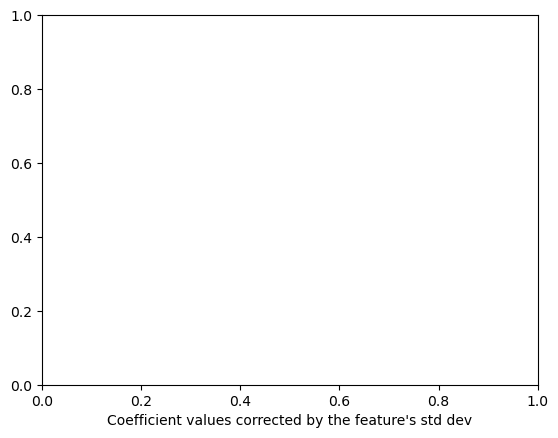

In [5]:
import numpy as np
summary_plot.selected = list(np.where(penguins[penguins.species=="Gentoo"])[0]);

### Tying the plots together

To see how this works we’ll need a data map. For that we’ll need some preprocessing for the numeric columns of the penguins data, and UMAP.

In [6]:
from sklearn.preprocessing import RobustScaler
import umap

We can now build a data map out of the rescaled numeric penguins data, and create a PlotPane for it.

In [9]:
data_for_umap = RobustScaler().fit_transform(penguins.select_dtypes(include="number"))
penguin_datamap = umap.UMAP(random_state=37).fit_transform(data_for_umap)
plot = tnt.BokehPlotPane(
    penguin_datamap,
    labels=penguins.species,
    hover_text=penguins.island,
#    width=400,
#    height=400,
    legend_location="top_right",
    title="Penguins data map",
)

Finally we can link our previously constructed summary_plot `PlotSummaryPane` with our newly constructed `BokehPlotPane`.  This is done via our `link_to_plot` function which ties together the `.selected` properties of both panes.

In [10]:
summary_plot.link_to_plot(plot)
pn.Row(plot, summary_plot)

Row
    [0] BokehPlotPane(color_by_palette=['#1f77b4', '#ff7f0e', ...], color_by_vector=Series([], dtype: object), label_color_factors=['Adelie', 'Gentoo', ...], label_color_palette=['#1f77b4', '#ff7f0e', ...], labels=0      Adelie
1      Adeli..., name='Plot')
    [1] PlotSummaryPane(name='Summary', selected=[0, 0, 0, 0, 0, ...])

If you are running this in a notebook you can now select the lasso tool the leftmost plot and select a set of points.  You should see the coefficient values associated with the various features appear on the right.